First add the data functions to the path

In [1]:
import sys
import numpy as np
import pandas as pd
import copy
from netCDF4 import Dataset
from pathlib import Path
notebook_dir = !pwd # Replace with !echo %cd% if using windows
library_dir = Path(notebook_dir[0]).parent.absolute()
sys.path.append(str(library_dir))
data_raw_path = library_dir / 'data' / 'raw'

from src.data.adcp_mission_analysis import adcp_import_data, add_dive_averages
from src.data.beam_mapping import beam2enu, beam_from_center

Use better plotting defaults

In [2]:
import matplotlib.pyplot as plt
from matplotlib import style
style_path = library_dir / 'src' / 'visualization' / 'presentation.mplstyle'
style.use(str(style_path))

Get an overview of the dataset

In [27]:
overview, mission_dict = adcp_import_data(data_raw_path)
overview

,file_path,dive_limb,averaging_interval,powerusage_mW,mem_usage_MB_per_hour,cell_size,measurement_interval,num_cells,num_pings,blank_dist,vert_direction
0001a,/home/callum/Documents/adcp-glider/data/raw/cp...,a,1,184.039993,0.061,2.0,15,15,4,0.3,Descent
0001b,/home/callum/Documents/adcp-glider/data/raw/cp...,b,1,184.039993,0.061,2.0,15,15,4,0.3,Ascent
0002a,/home/callum/Documents/adcp-glider/data/raw/cp...,a,1,184.039993,0.061,2.0,15,15,4,0.3,Descent
0002b,/home/callum/Documents/adcp-glider/data/raw/cp...,b,1,184.039993,0.061,2.0,15,15,4,0.3,Ascent
0003a,/home/callum/Documents/adcp-glider/data/raw/cp...,a,1,184.039993,0.061,2.0,15,15,4,0.3,Descent
...,...,...,...,...,...,...,...,...,...,...,...
0153b,/home/callum/Documents/adcp-glider/data/raw/cp...,b,1,184.039993,0.061,2.0,15,15,4,0.3,Ascent
0154a,/home/callum/Documents/adcp-glider/data/raw/cp...,a,1,184.039993,0.061,2.0,15,15,4,0.3,Descent
0154b,/home/callum/Documents/adcp-glider/data/raw/cp...,b,1,184.039993,0.061,2.0,15,15,4,0.3,Ascent
0155a,/home/callum/Documents/adcp-glider/data/raw/cp...,a,1,184.039993,0.061,2.0,15,15,4,0.3,Descent


Add beam attributes. These are taken from the fifth cell. 11.3 m from the glider on default settings.

In [43]:
beam_attrs = add_dive_averages(overview, mission_dict)
beam_attrs

,cor_beam_1,cor_beam_2,cor_beam_3,cor_beam_4,amp_beam_1,amp_beam_2,amp_beam_3,amp_beam_4,beam_miss,pitch,roll,heading,good_angle
0001a,NaN,20.1064,16.4255,17.2128,NaN,29.6702,29.0426,29.3511,2.6974,-42.6309,4.44085,235.983,6.38298
0001b,46.8214,48.8571,NaN,46.3214,33.6964,33.2946,NaN,32.8571,1.87585,-12.9293,4.59,184.709,32.1429
0002a,NaN,63.5455,62.8,62.7091,NaN,34.8818,34.5636,34.3455,1.60773,-29.5591,5.61491,115.971,40
0002b,88.1833,87.6667,NaN,86.35,37.8167,37.2583,NaN,36.7417,0.898507,16.1588,5.542,134.029,60
0003a,NaN,73.8457,75.9074,73.6296,NaN,33.2438,33.7346,33.0463,0.821654,-16.9001,4.67148,115.131,54.9383
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0153b,96.5814,96.0698,NaN,95.6977,42.7674,42.1163,NaN,41.5233,0.77738,25.4237,2.5007,106.602,83.7209
0154a,NaN,92.7059,93.2353,94.7059,NaN,39.0294,40.4706,39.7059,1.54943,-26.01,3.98588,35.48,47.0588
0154b,95.7857,95.1429,NaN,95.1429,41.7143,41,NaN,40.6429,0.983536,24.1043,4.05286,97.7407,64.2857
0155a,NaN,93.8889,91.9259,93.5926,NaN,39.6481,40.0926,39,1.37718,-26.317,4.59037,180.342,33.3333


In [ ]:
beam_attrs.plot(subplots=True,figsize=(20,20),marker='o')

After 20 dives, the glider should be trimmed and on deep dives.

In [6]:
foo = mission_dict['0021a']
bar = mission_dict['0021b']

In [35]:
mens = []
mene = []
menn = []
menu = []
for ident in list(mission_dict):
    mens.append(np.nanmean(mission_dict[ident].vel_enu))
    mene.append(np.nanmean(mission_dict[ident].vel_enu[:,:,0]))
    menn.append(np.nanmean(mission_dict[ident].vel_enu[:,:,1]))
    menu.append(np.nanmean(mission_dict[ident].vel_enu[:,:,2]))

In [17]:
mens2 = []
for ident in list(mission_dict):
    mens2.append(np.nanmean(mission_dict[ident].vel_beam))

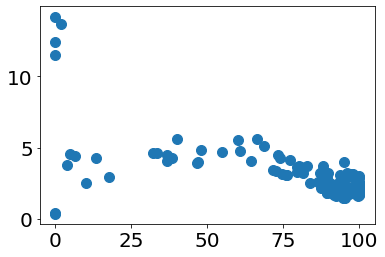

In [33]:
plt.scatter(beam_attrs.good_angle, beam_attrs.roll)

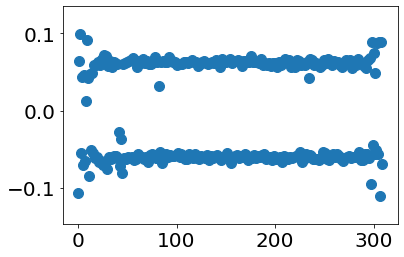

In [19]:
plt.scatter(np.arange(len(mens)), mens2)

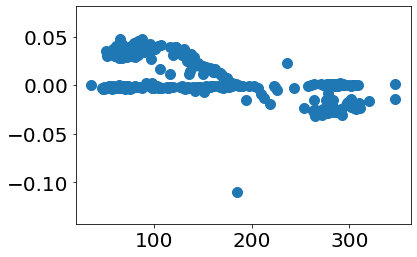

In [26]:
plt.scatter(beam_attrs['heading'], mens)

[(-0.02, 0.02)]

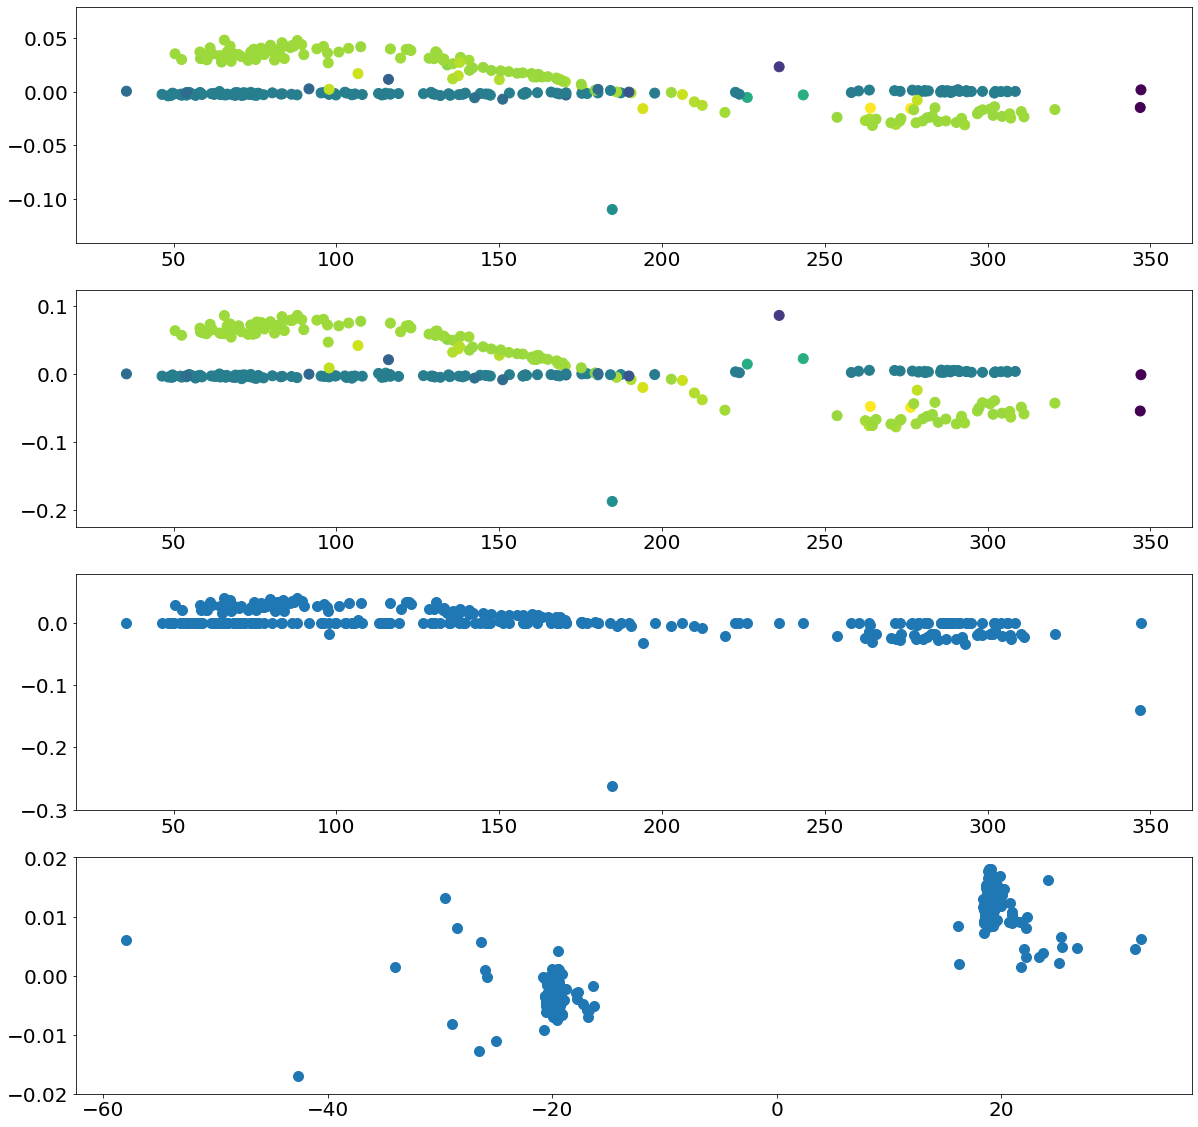

In [50]:
fig, ax = plt.subplots(4,1,figsize=(20,20))
ax = ax.ravel()
ax[0].scatter(beam_attrs['heading'],mens,label='all', c=beam_attrs['pitch'])
ax[1].scatter(beam_attrs['heading'],mene,label='east', c=beam_attrs['pitch'])
ax[2].scatter(beam_attrs['heading'],menn,label='north')
ax[3].scatter(beam_attrs['pitch'],menu,label='up')
ax[3].set(ylim=[-0.02,0.02])

In [ ]:
overview.join(beam_attrs)

In [51]:
uvw2beam_climb = np.array(
    ((np.sin(np.deg2rad(47.5)), 0., np.cos(np.deg2rad(47.5))),
     (0, np.sin(np.deg2rad(25)), np.cos(np.deg2rad(25))),
     (0, -np.sin(np.deg2rad(25)), np.cos(np.deg2rad(25)))))
beam2uvw_climb = np.linalg.inv(uvw2beam_climb)

uvw2beam_dive = np.array(
    ((0, np.sin(np.deg2rad(25)), np.cos(np.deg2rad(25))),
    (-np.sin(np.deg2rad(47.5)), 0.,np.cos(np.deg2rad(47.5))),
    (0, -np.sin(np.deg2rad(25)),np.cos(np.deg2rad(25)))))
beam2uvw_dive = np.linalg.inv(uvw2beam_dive)

In [ ]:
b2c = np.array(
    (()))

In [54]:
noot = foo.ad2cp_dict
noot['Physicalbeam'][0,:]

masked_array(data=[2., 3., 4., 0.],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [55]:
noot

OrderedDict([('time', <class 'netCDF4._netCDF4.Variable'>
              float64 time(time)
                  units: seconds since 1970-01-01T00:00:00 UTC
                  description: time of measurement
                  calendar: gregorian
              path = /Data/Average
              unlimited dimensions: 
              current shape = (278,)
              filling off),
             ('Velocity Range', <class 'netCDF4._netCDF4.Variable'>
              float32 Velocity Range(Velocity Range)
                  units: m
                  description: 
              path = /Data/Average
              unlimited dimensions: 
              current shape = (15,)
              filling off),
             ('VelocityBeam1', <class 'netCDF4._netCDF4.Variable'>
              float32 VelocityBeam1(time, Velocity Range)
                  units: m/s
                  description: 
              path = /Data/Average
              unlimited dimensions: 
              current shape = (278, 15)
      